In [70]:
#Libraries
import pandas as pd
import numpy as np
from pathlib import Path #this library minimizes issues when using paths in Mac
import os
#pip install dataprep --user
from dataprep.eda import create_report
import re
import datetime
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import streamlit as st

from scipy.stats.mstats import winsorize
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split,GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer


import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#pip freeze > requirements.txt

In [3]:
#Seaborn Context
sns.set_theme(style='whitegrid', context='paper', palette='deep')
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));
#sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot
#plt.figure(figsize=(9, 5)) 

In [4]:
#List of Folders
prod_folder = Path("data/Value_of_Production_E_All_Data")
pop_folder = Path("data/Population_E_All_Data")

In [5]:
def clean_fao_df(df,element, drop_columns,value_column):
    #remove flags
    df = df[df.columns.drop(list(df.filter(regex='.*?F')))]
    #filter by element
    df = df[df["Element"]==element]
    #drop columns
    df = df[df.columns.drop(drop_columns)]
    #wide_to_long by year
    df=pd.wide_to_long(df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()
    df.rename(columns = {'Y':value_column}, inplace = True)
    return df

In [6]:
prod_df = pd.read_csv(prod_folder /"Value_of_Production_E_All_Data.csv", encoding = 'unicode_escape')
prod_df.head()

Area Code Area Code (M49)         Area  Item Code Item Code (CPC)  \
0          2            '004  Afghanistan        221          '01371   
1          2            '004  Afghanistan        221          '01371   
2          2            '004  Afghanistan        221          '01371   
3          2            '004  Afghanistan        711          '01654   
4          2            '004  Afghanistan        515          '01341   

                                                Item  Element Code  \
0                                  Almonds, in shell           152   
1                                  Almonds, in shell            56   
2                                  Almonds, in shell            55   
3  Anise, badian, coriander, cumin, caraway, fenn...           152   
4                                             Apples           152   

                                             Element         Unit   Y1961  \
0  Gross Production Value (constant 2014-2016 tho...  1000 Int. $     NaN   
1      Gross Production Value (current thousand SLC)     1000 SLC     NaN   
2  Gross Production Value (constant 2014-2016 tho...     1000 SLC     NaN   
3  Gross Production Value (constant 2014-2016 tho...  1000 Int. $     NaN   
4  Gross Production Value (constant 2014-2016 tho...  1000 Int. $  7127.0   

   ...      Y2016  Y2016F      Y2017  Y2017F      Y2018  Y2018F      Y2019  \
0  ...   166057.0       E   137986.0       E   173995.0       E   193168.0   
1  ...  6539411.0       E  5213293.0       E  6239642.0       E  6707803.0   
2  ...  7004306.0       E  5820251.0       E  7339134.0       E  8147840.0   
3  ...    37675.0       E    41176.0       E    39326.0       E    39392.0   
4  ...    66506.0       E    80449.0       E   102515.0       E   118153.0   

   Y2019F      Y2020  Y2020F  
0       E   198739.0       E  
1       E  7160695.0       E  
2       E  8382859.0       E  
3       E    39965.0       E  
4       E   127845.0       E  

[5 rows x 129 columns]

In [7]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code","Item Code (CPC)", "Element", "Element Code", "Unit"]
prod_df = clean_fao_df(prod_df, 'Gross Production Value (constant 2014-2016 thousand I$)', drop_columns, 'Total_Prod' )

In [8]:
#Chose 2019 as 2020 could be impacted by Covid
#https://www.nature.com/articles/s41599-022-01080-0
#The study concluded that interruptions in agricultural food supply as a result of the pandemic impacted supply and demand shocks with negative impacts on all the four pillars of food security.
prod19_df=prod_df[prod_df["Year"]==2019]
prod19_df = prod19_df[prod19_df.columns.drop(['Year'])]

In [9]:
pop_df = pd.read_csv(pop_folder /"Population_E_All_Data_NOFLAG.csv", encoding = 'unicode_escape')

In [10]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code", "Element", "Element Code", "Unit"]
pop_df = clean_fao_df(pop_df, 'Total Population - Both sexes', drop_columns, 'Total_Population' )
pop19_df=pop_df[pop_df["Year"]==2019]
pop19_df = pop19_df[pop19_df.columns.drop(['Item', 'Year'])]
pop19_df.head()

Area  Total_Population
69      Afghanistan         37769.499
220         Albania          2873.883
371         Algeria         42705.368
522  American Samoa            47.321
673         Andorra            76.343

In [11]:
prod19_df=prod19_df.merge(pop19_df, how='left', on='Area') 

In [12]:
prod19_df['Prod_Capita']=prod19_df['Total_Prod']/prod19_df['Total_Population']
prod19_df = prod19_df[prod19_df.columns.drop(['Total_Prod', 'Total_Population'])]

In [13]:
prod19_df.head()

Area                                               Item  Prod_Capita
0  Afghanistan                                  Almonds, in shell     5.114391
1  Afghanistan  Anise, badian, coriander, cumin, caraway, fenn...     1.042958
2  Afghanistan                                             Apples     3.128265
3  Afghanistan                                           Apricots     2.805306
4  Afghanistan                                             Barley     0.637446

In [14]:
prod19_df=prod19_df.pivot(index='Area', columns='Item', values='Prod_Capita')

In [15]:
prod19_df=prod19_df.reset_index(level=0)

In [16]:
#Noticed that there are Areas that are not countries, but groups of them ("World", "Americas", etc.)
#Downloaded the groups file to remove them at once
pop_group_df = pd.read_csv(pop_folder /"Population_E_All_Area_Groups_NOFLAG.csv", encoding = 'unicode_escape')

In [17]:
prod19_df = prod19_df[~prod19_df['Area'].isin(pop_group_df['Area'].unique())] 

In [18]:
prod19_df.head()

Item                 Area  Abaca, manila hemp, raw  Agave fibres, raw, n.e.c.  \
0             Afghanistan                      NaN                        NaN   
2                 Albania                      NaN                        NaN   
3                 Algeria                      NaN                        NaN   
5                  Angola                      NaN                        NaN   
6     Antigua and Barbuda                      NaN                        NaN   

Item  Agriculture  Almonds, in shell  \
0      174.078401           5.114391   
2      736.821228                NaN   
3      364.737754           8.573185   
5      190.689824                NaN   
6       92.230533                NaN   

Item  Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw  \
0                                              1.042958                           
2                                                   NaN                           
3                                                   NaN                           
5                                                   NaN                           
6                                                   NaN                           

Item     Apples  Apricots  Areca nuts  Artichokes  ...  \
0      3.128265  2.805306         NaN         NaN  ...   
2     17.398412  1.389409         NaN         NaN  ...   
3      6.176483  4.012376         NaN    1.941981  ...   
5           NaN       NaN         NaN         NaN  ...   
6           NaN       NaN         NaN         NaN  ...   

Item  Unmanufactured tobacco  Vanilla, raw  Vegetables Primary  \
0                        NaN           NaN           12.133944   
2                   1.093294           NaN          151.655095   
3                   0.795263           NaN           73.969390   
5                   0.201152           NaN            6.316054   
6                        NaN           NaN            6.622013   

Item  Vegetables and Fruit Primary   Vetches  Walnuts, in shell  Watermelons  \
0                        62.010804       NaN            1.22771     5.202902   
2                       307.200398  0.251924                NaN    20.965711   
3                       159.457167  0.000679                NaN    11.989523   
5                        63.896623       NaN                NaN          NaN   
6                        64.928298       NaN                NaN          NaN   

Item      Wheat      Yams  Yautia  
0     30.662361       NaN     NaN  
2     19.218945       NaN     NaN  
3     21.499944       NaN     NaN  
5      0.021667       NaN     NaN  
6           NaN  0.390807     NaN  

[5 rows x 200 columns]

In [19]:
cols=['Area','Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary']
prod19_df=prod19_df[cols]

In [20]:
print("There are",prod19_df.shape[1]-1, "products and", prod19_df.shape[0], "countries.\n")
print("The Products with most null values are:")
print(prod19_df.isnull().sum().sort_values(ascending=False).head(5).to_string())


There are 8 products and 211 countries.

The Products with most null values are:
Item
Sugar Crops Primary    77
Non Food               36
Cereals, Total         31
Milk, Total            24
Vegetables Primary     16


In [21]:
#Drop countries with more than 50% of values null
prod19_df.dropna(thresh=(prod19_df.shape[1]+1)/2, inplace=True)

In [22]:
#Check: 
#print(prod19_df.isna().sum(axis=1).sort_values(ascending=False).head(20).to_string())

In [23]:
prod19_df.describe().T

count        mean         std       min        25%  \
Item                                                                          
Cereals, Total           180.0   77.019542   97.848773  0.002793  11.489062   
Fruit Primary            194.0   60.153664   68.857705  0.000341  15.475891   
Meat indigenous, total   195.0  116.362872  147.878527  1.027024  32.067347   
Milk, Total              187.0   67.643678  154.882531  0.003335   6.713263   
Non Food                 175.0   11.186390   23.153876  0.011473   1.034110   
Roots and Tubers, Total  194.0   28.114953   51.481350  0.000511   5.653638   
Sugar Crops Primary      134.0   16.066358   33.464111  0.001862   1.079345   
Vegetables Primary       194.0   31.180197   33.792774  0.323232   9.480679   

                               50%         75%          max  
Item                                                         
Cereals, Total           39.850869   94.290468   415.269755  
Fruit Primary            38.262886   77.354095   498.016533  
Meat indigenous, total   72.294603  138.024087  1143.134127  
Milk, Total              24.719916   89.946427  1828.248606  
Non Food                  4.444478   10.504840   230.533608  
Roots and Tubers, Total  14.179483   30.016120   581.988548  
Sugar Crops Primary       5.499088   14.819981   220.159147  
Vegetables Primary       17.115678   40.076852   176.513701

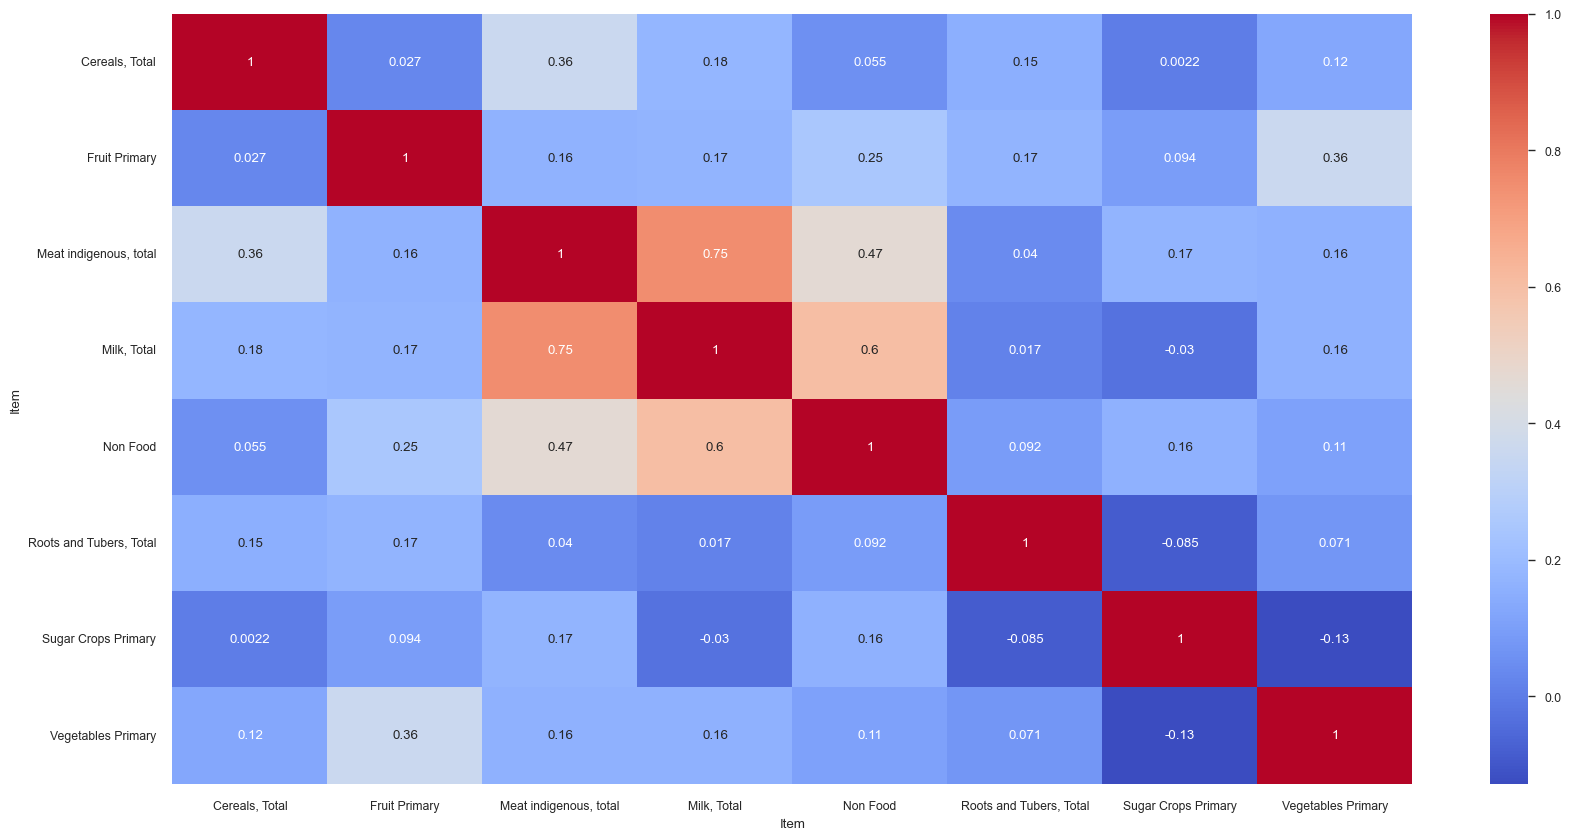

In [24]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(prod19_df.corr(),annot = True, cmap='coolwarm')
plt.show()

In [25]:
#featurewiz does not work for clustering or unsupervised problems
#pip install featurewiz --user

In [26]:
prod19_df.fillna(0, inplace=True)

In [27]:
prod19_df.set_index('Area', inplace=True)
prod19_df.head()

Item                 Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                         
Afghanistan               36.263282      49.876860               30.440250   
Albania                   49.112995     155.545650               96.876247   
Algeria                   29.452386      85.487778               64.256817   
Angola                    18.371780      57.580569               30.352553   
Antigua and Barbuda        0.108558      58.306284                4.505140   

Item                 Milk, Total   Non Food  Roots and Tubers, Total  \
Area                                                                   
Afghanistan            24.313719   2.170455                 6.103549   
Albania               167.844690  17.509759                22.699254   
Algeria                35.373773   3.959409                29.420493   
Angola                  2.807108   1.636325                54.670691   
Antigua and Barbuda    13.808526   0.000000                 1.107287   

Item                 Sugar Crops Primary  Vegetables Primary  
Area                                                          
Afghanistan                     0.054991           12.133944  
Albania                         0.503500          151.655095  
Algeria                         0.000000           73.969390  
Angola                          1.040472            6.316054  
Antigua and Barbuda             0.000000            6.622013

In [28]:
#https://www.kaggle.com/code/emilytries/clustering-and-feature-selection
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in prod19_df.columns:
    replace_with_thresholds(prod19_df, col)

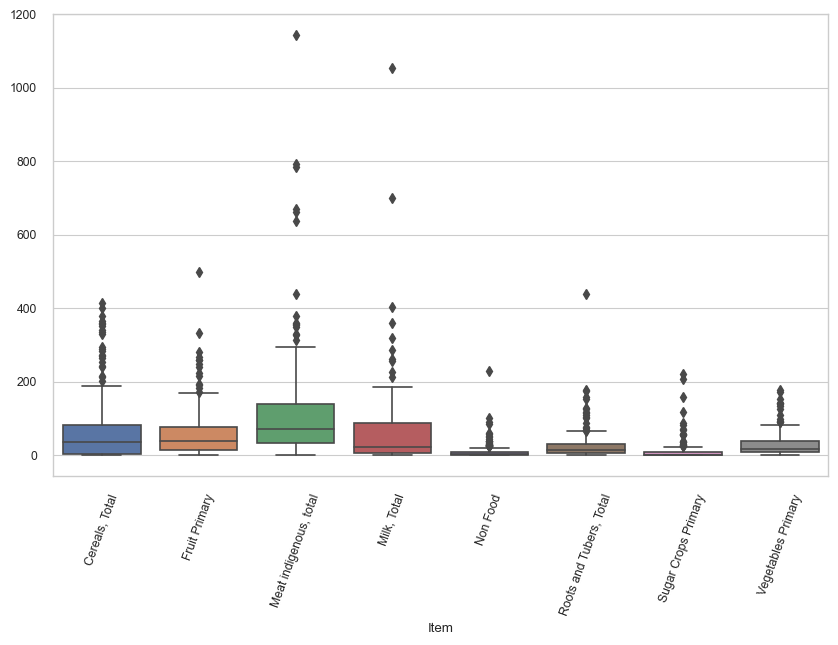

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(data=prod19_df)
plt.xticks(rotation=70)
plt.show()

In [30]:
# Min Max Scaler
names = prod19_df.columns
indexes = prod19_df.index
sc = MinMaxScaler((0, 1))
df = sc.fit_transform(prod19_df)
data_scaled = pd.DataFrame(df, columns=names, index=indexes)
data_scaled.head()

Item                 Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                         
Afghanistan                0.087325       0.100151                0.025753   
Albania                    0.118268       0.312330                0.083923   
Algeria                    0.070924       0.171657                0.055362   
Angola                     0.044241       0.115620                0.025677   
Antigua and Barbuda        0.000261       0.117077                0.003045   

Item                 Milk, Total  Non Food  Roots and Tubers, Total  \
Area                                                                  
Afghanistan             0.023100  0.009416                 0.013908   
Albania                 0.159464  0.075962                 0.051724   
Algeria                 0.033608  0.017177                 0.067039   
Angola                  0.002667  0.007099                 0.124576   
Antigua and Barbuda     0.013119  0.000000                 0.002523   

Item                 Sugar Crops Primary  Vegetables Primary  
Area                                                          
Afghanistan                     0.000250            0.068742  
Albania                         0.002287            0.859169  
Algeria                         0.000000            0.419057  
Angola                          0.004726            0.035782  
Antigua and Barbuda             0.000000            0.037516

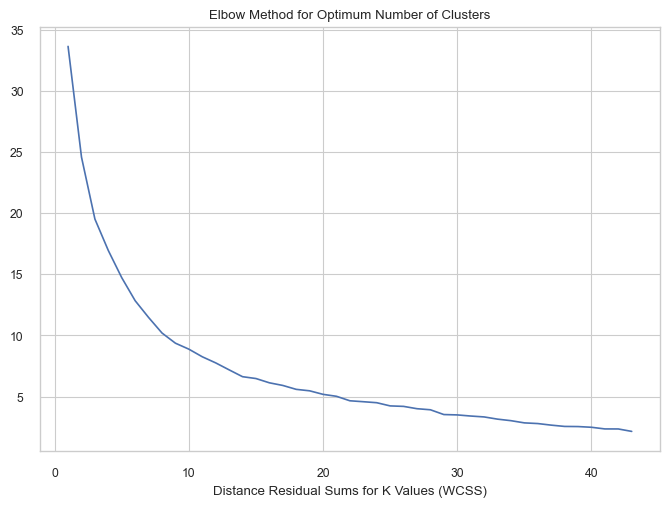

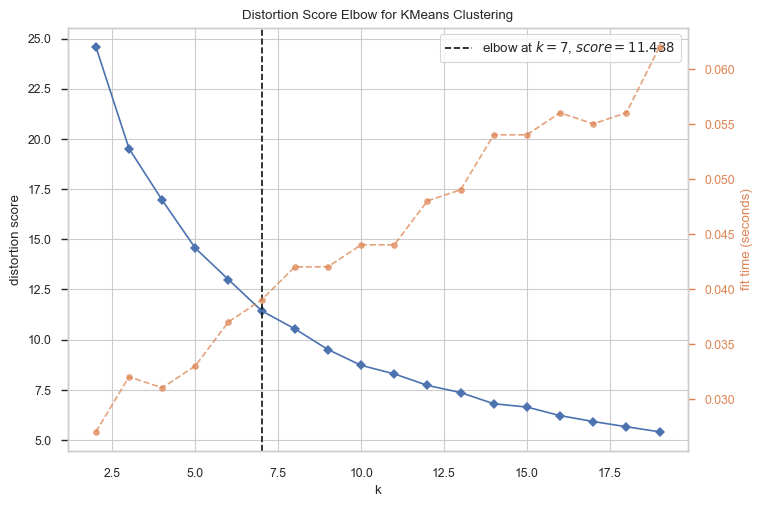

In [31]:
# KMeans Clustering
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
kmeans = KMeans()
ssd = []
K = range(1, 44)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    ssd.append(kmeans.inertia_)

ssd

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
fig = KElbowVisualizer(kmeans, k=(2, 20))
fig.fit(df)
fig.show();

In [32]:
kmeans = KMeans(n_clusters=8).fit(data_scaled)
clusters = kmeans.labels_

pd.DataFrame({"Customers": prod19_df.index, "Clusters": clusters})
prod19_df["cluster_no"] = clusters
prod19_df.head()

Item                 Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                         
Afghanistan               36.263282      49.876860               30.440250   
Albania                   49.112995     155.545650               96.876247   
Algeria                   29.452386      85.487778               64.256817   
Angola                    18.371780      57.580569               30.352553   
Antigua and Barbuda        0.108558      58.306284                4.505140   

Item                 Milk, Total   Non Food  Roots and Tubers, Total  \
Area                                                                   
Afghanistan            24.313719   2.170455                 6.103549   
Albania               167.844690  17.509759                22.699254   
Algeria                35.373773   3.959409                29.420493   
Angola                  2.807108   1.636325                54.670691   
Antigua and Barbuda    13.808526   0.000000                 1.107287   

Item                 Sugar Crops Primary  Vegetables Primary  cluster_no  
Area                                                                      
Afghanistan                     0.054991           12.133944           1  
Albania                         0.503500          151.655095           2  
Algeria                         0.000000           73.969390           6  
Angola                          1.040472            6.316054           1  
Antigua and Barbuda             0.000000            6.622013           1

In [33]:
#prod19_df["cluster_no"] = prod19_df["cluster_no"] + 1
prod19_df.groupby("cluster_no").agg({"cluster_no": "count"})

Item        cluster_no
cluster_no            
0                   15
1                  102
2                    9
3                    1
4                   23
5                   10
6                   31
7                    4

In [34]:
prod19_df.groupby("cluster_no").agg(np.mean)

Item        Cereals, Total  Fruit Primary  Meat indigenous, total  \
cluster_no                                                          
0               334.588546      68.805203              314.300828   
1                21.107060      30.942020               68.294676   
2                71.732759     124.587464              152.576201   
3                43.675442     258.049854             1143.134127   
4               173.326966      35.559257              160.860358   
5                45.548248     265.332650              101.975360   
6                44.094784      74.787892              100.411081   
7                48.389479      78.173926              165.396330   

Item        Milk, Total    Non Food  Roots and Tubers, Total  \
cluster_no                                                     
0            136.785758    9.493885                36.188564   
1             28.415933    6.485602                20.072659   
2            113.349199   12.281308                27.575177   
3           1052.555603  230.506524                26.762470   
4            121.469562   17.110920                37.681622   
5             44.035027   15.532849                71.768099   
6             49.205034    7.104309                26.625549   
7             22.814657   10.874977                 9.059685   

Item        Sugar Crops Primary  Vegetables Primary  
cluster_no                                           
0                     16.906161           34.932561  
1                      4.935647           12.526887  
2                      4.397956          143.832514  
3                      0.000000           70.813388  
4                     12.670138           28.818005  
5                     16.692627           32.201982  
6                      6.233368           59.570789  
7                    176.177033           12.598229

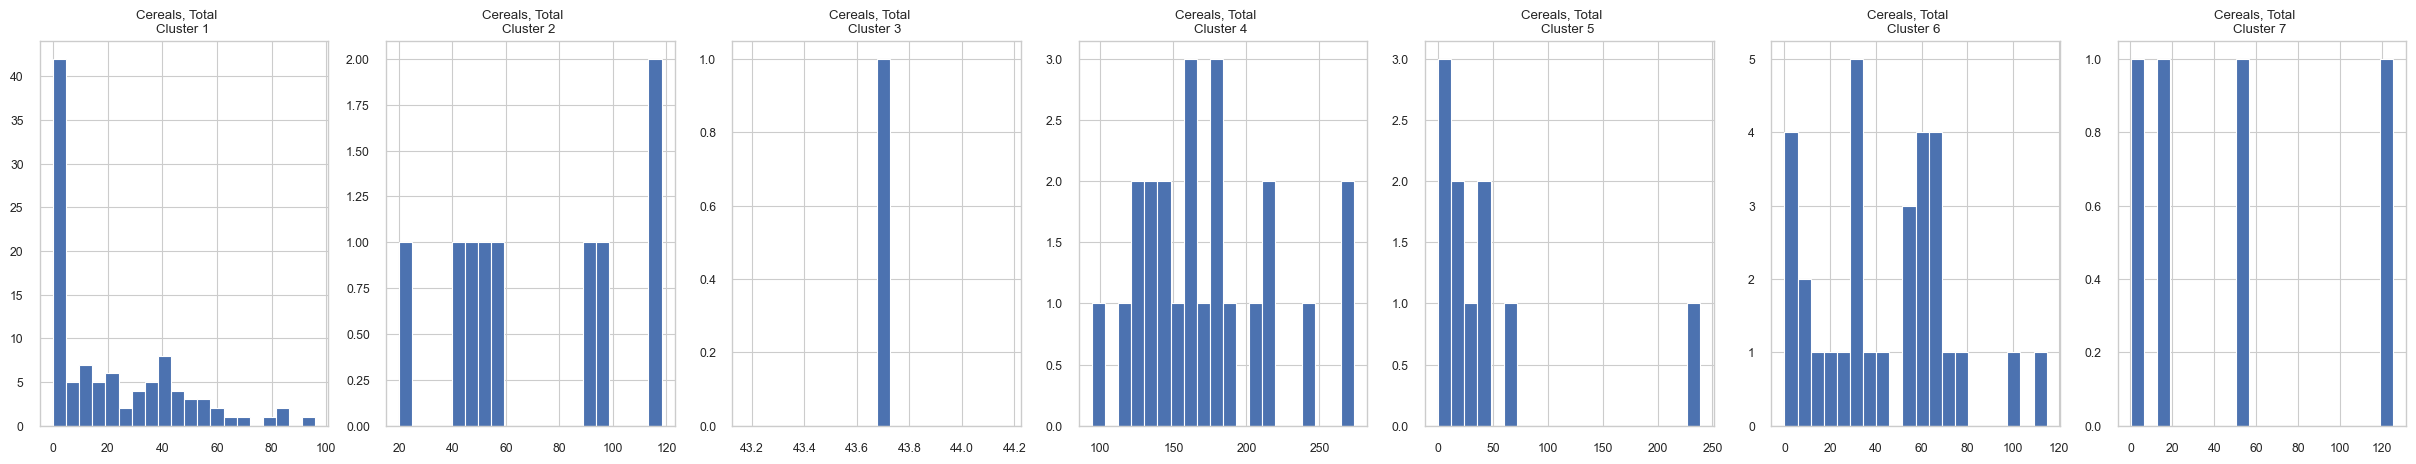

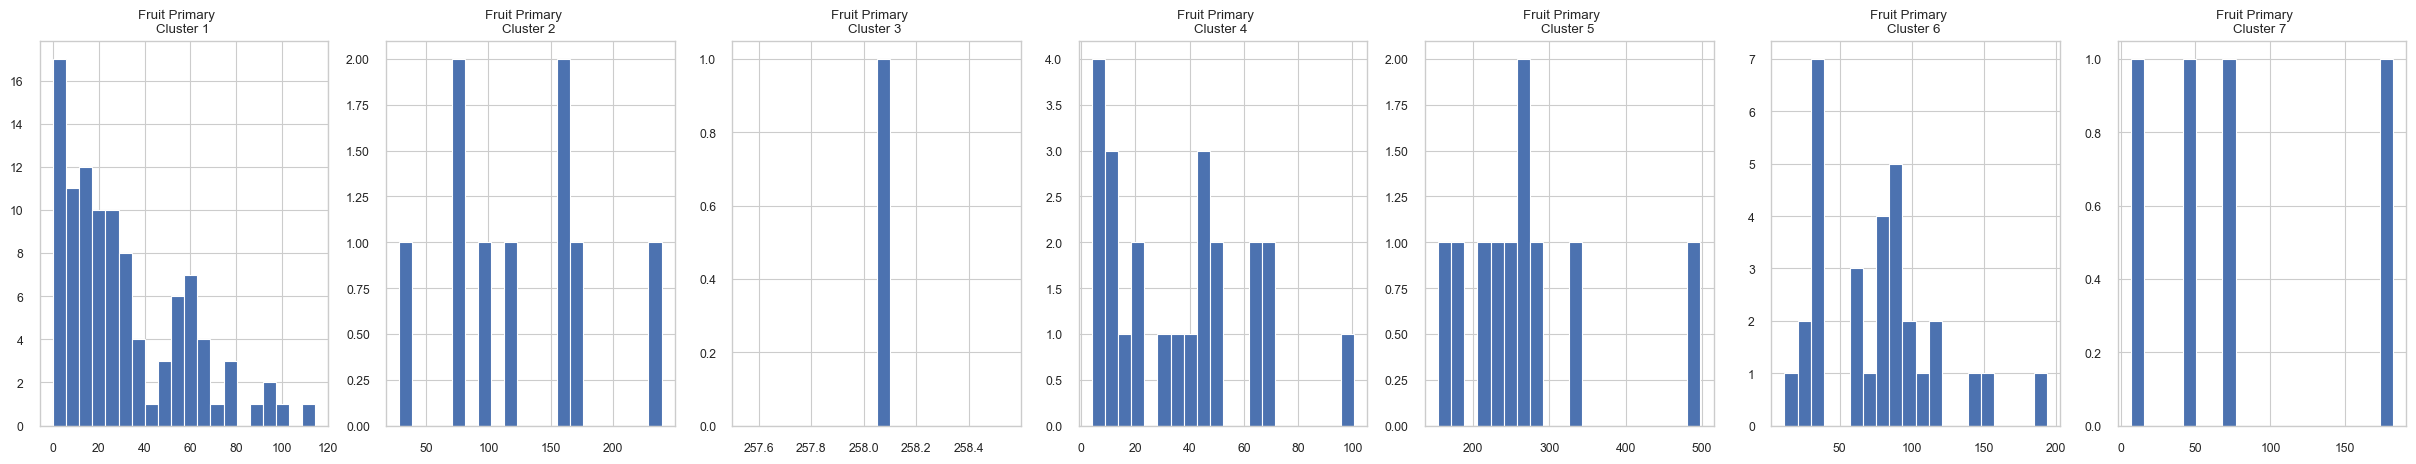

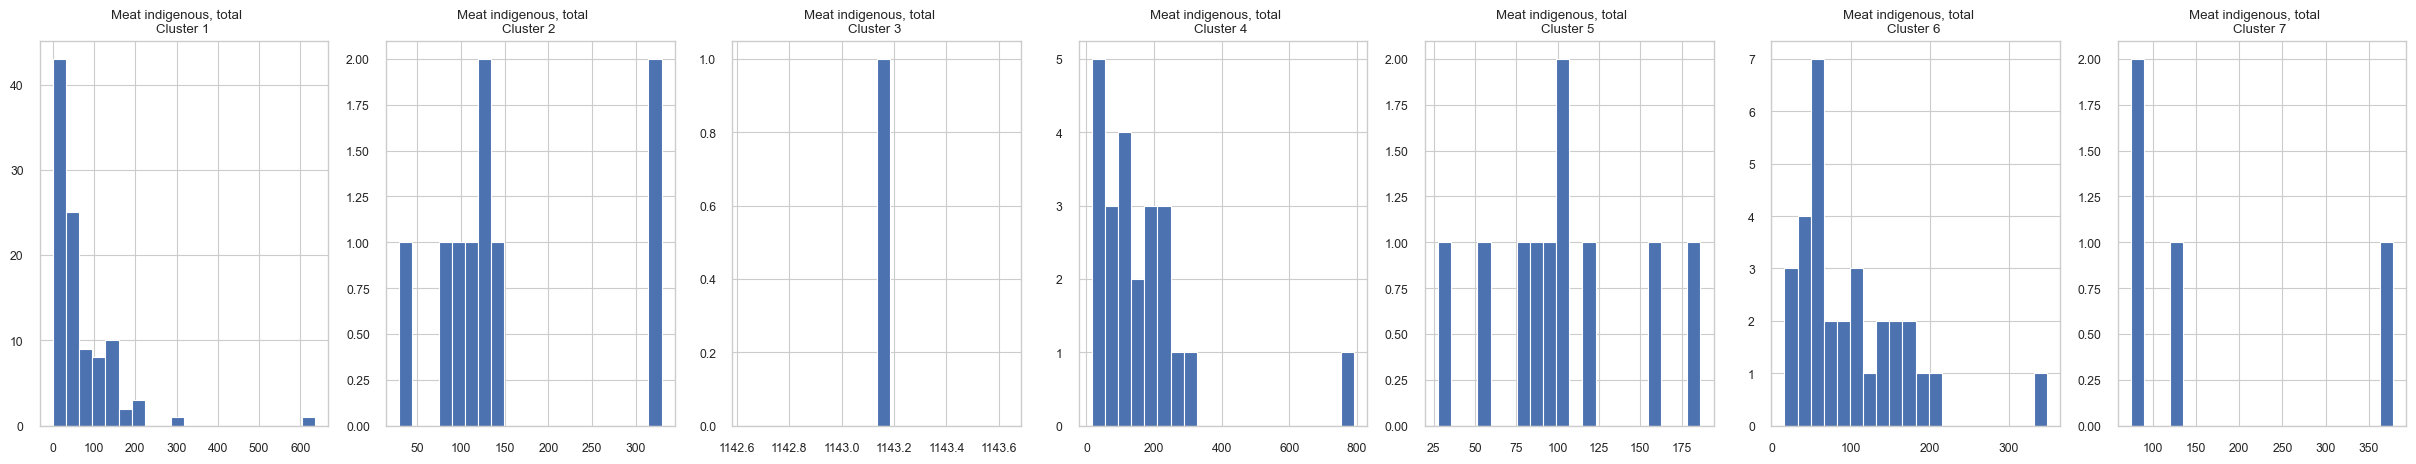

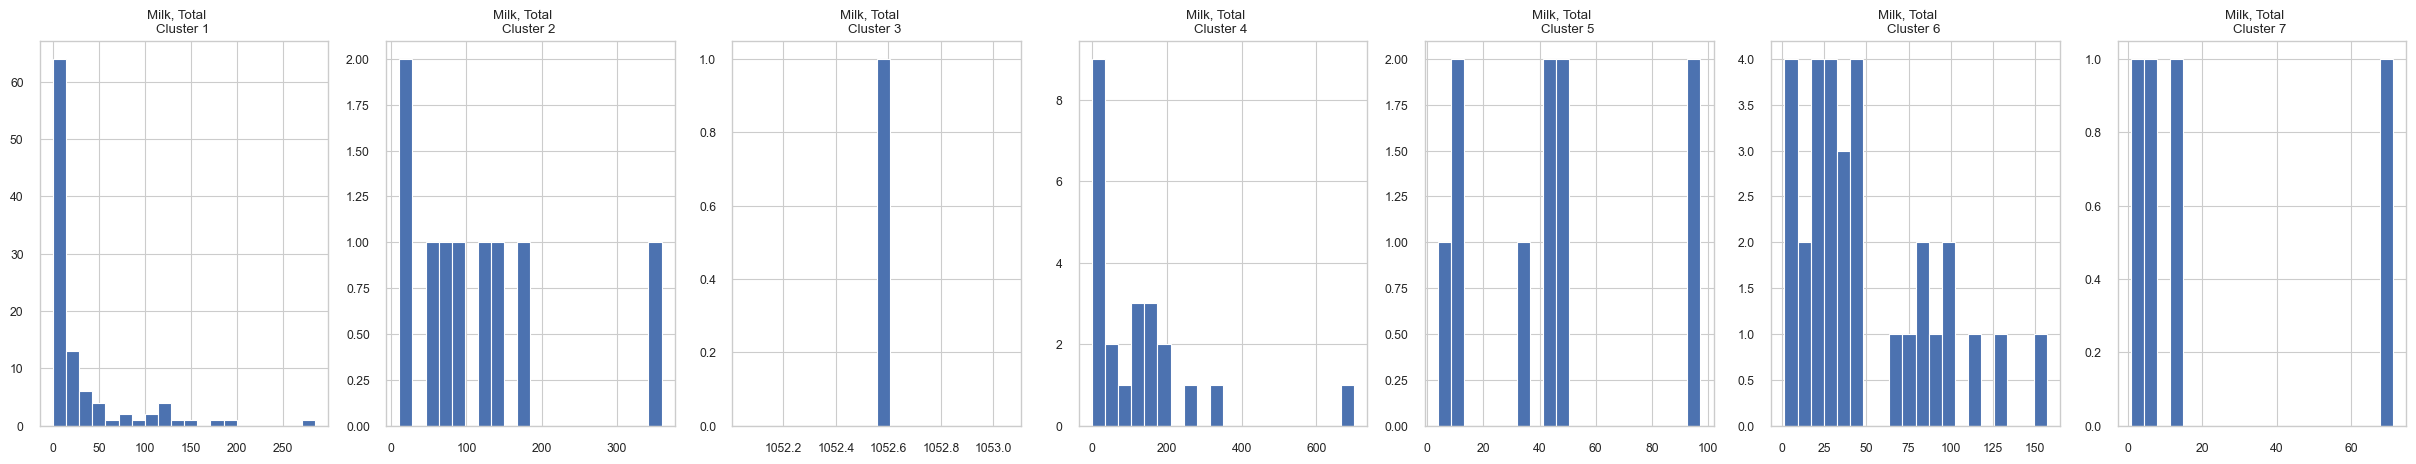

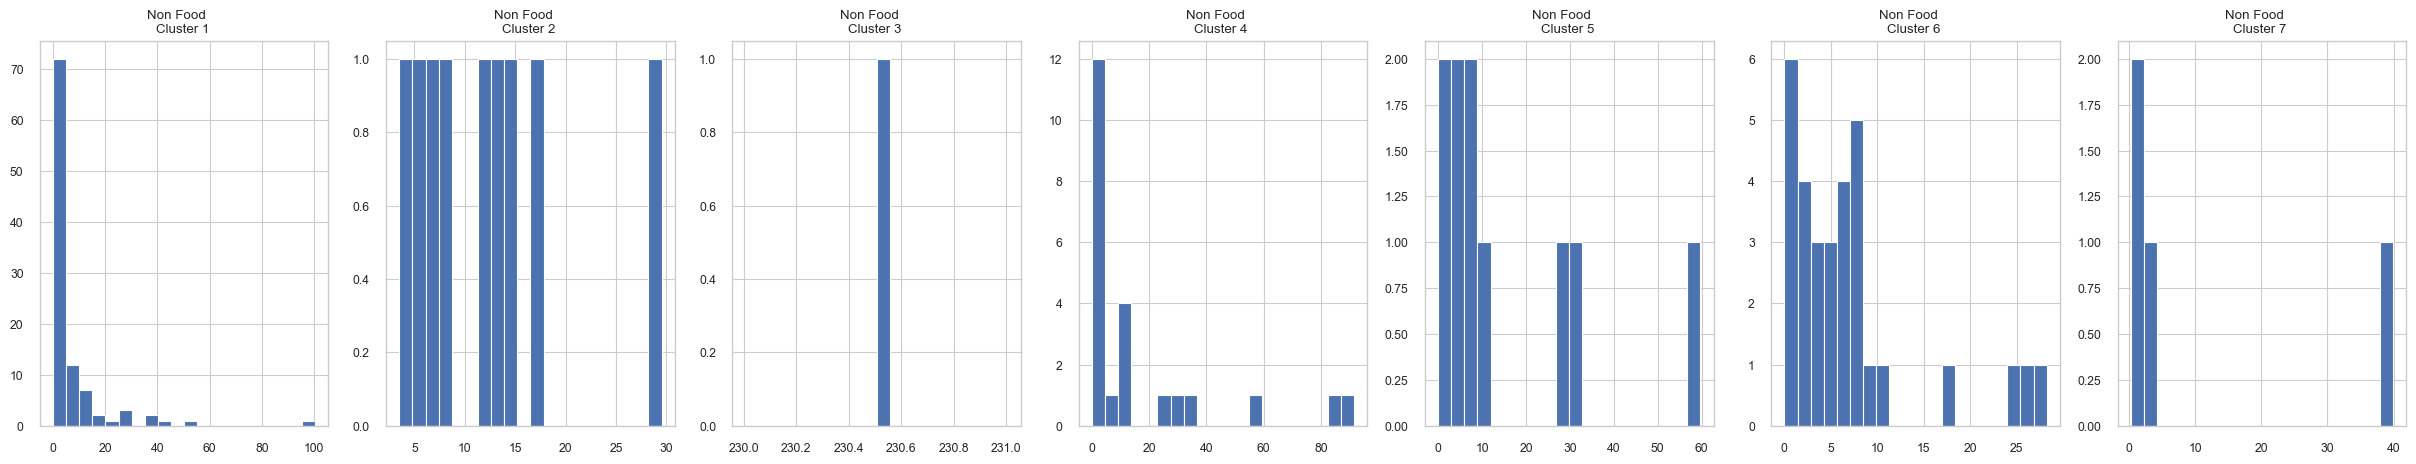

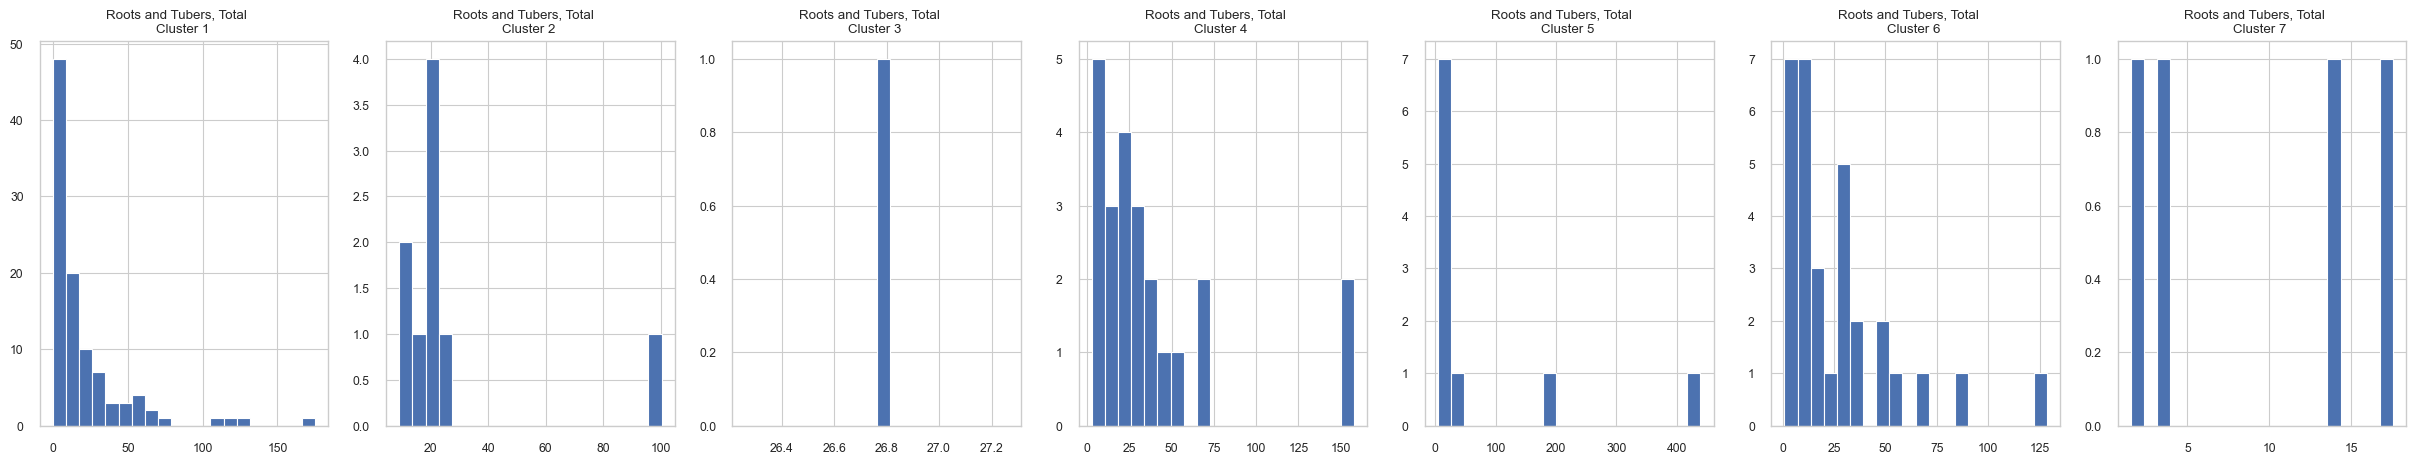

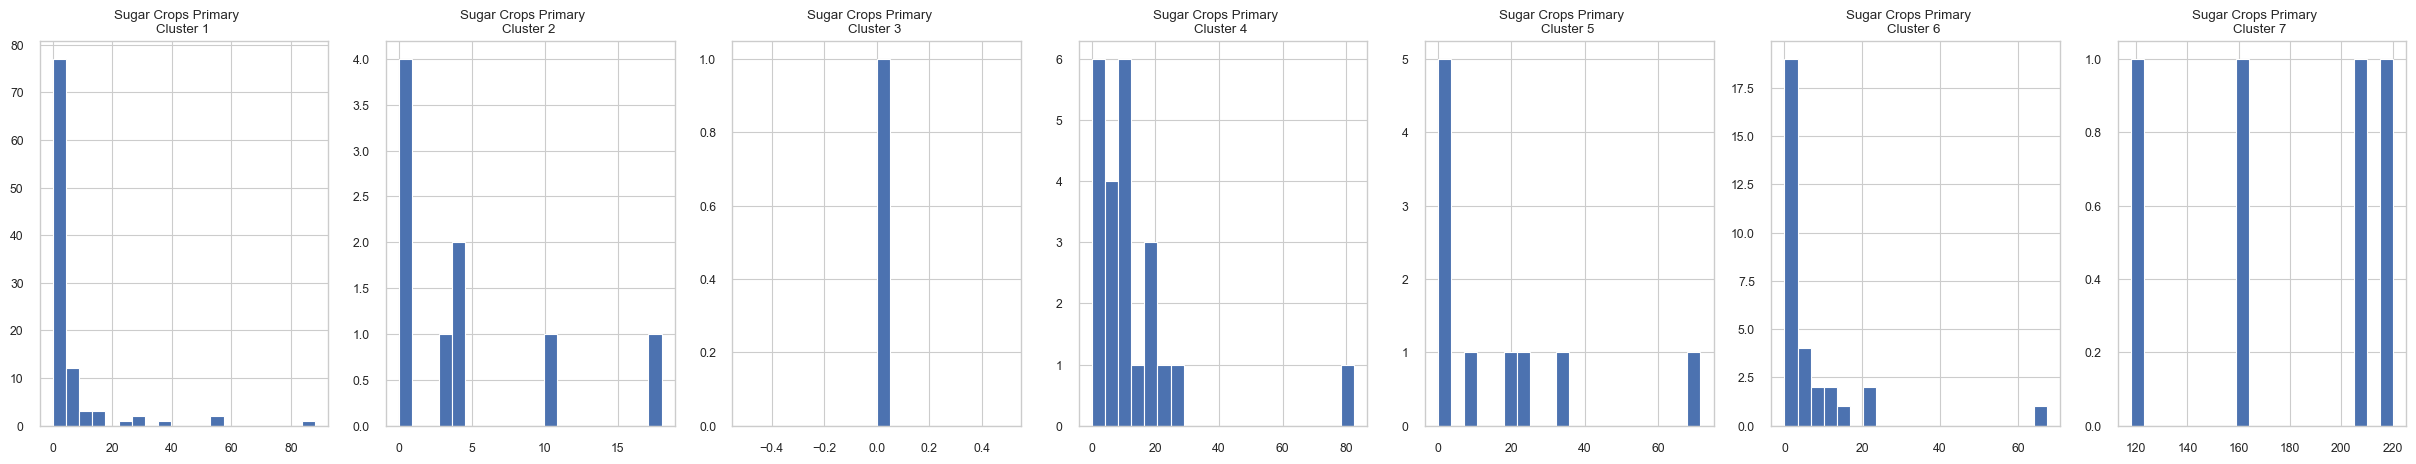

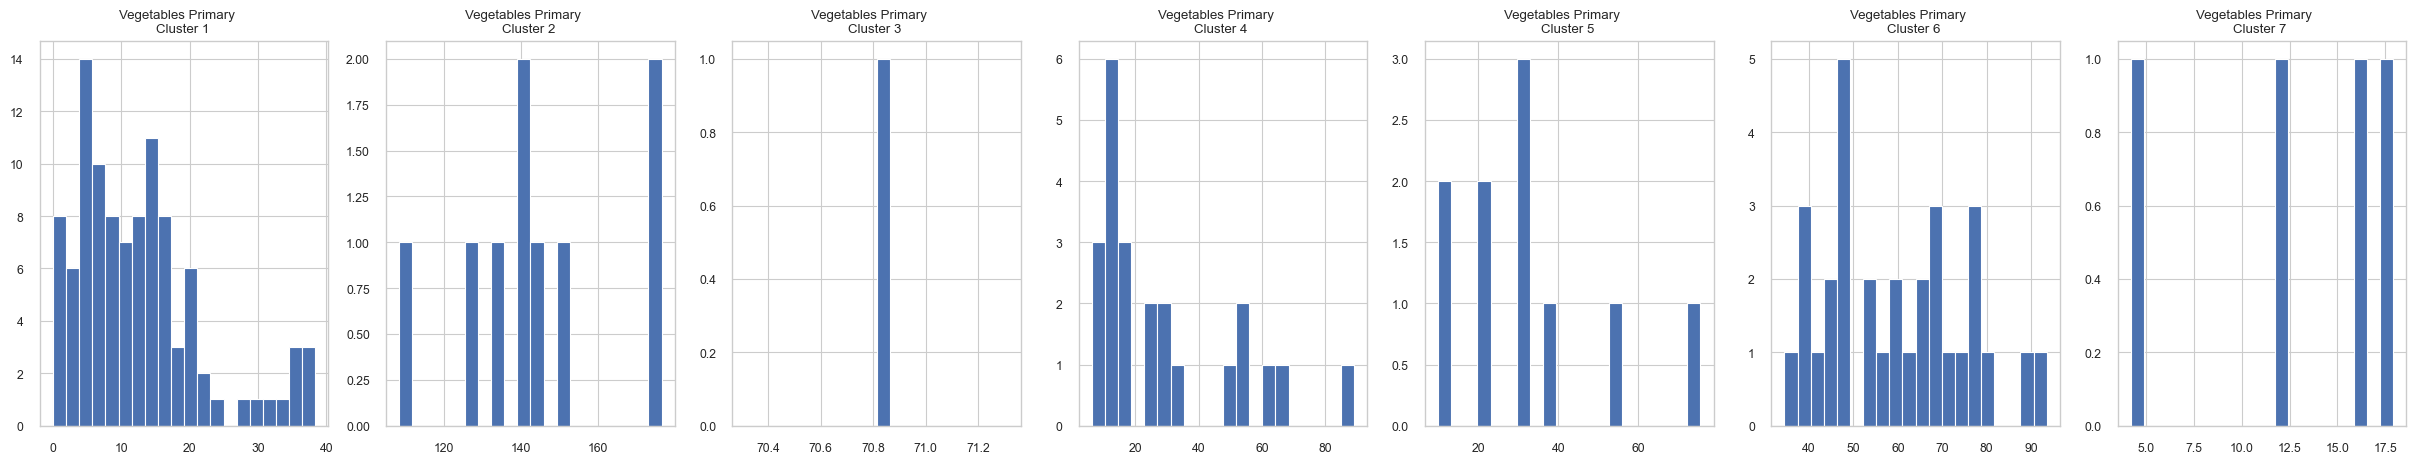

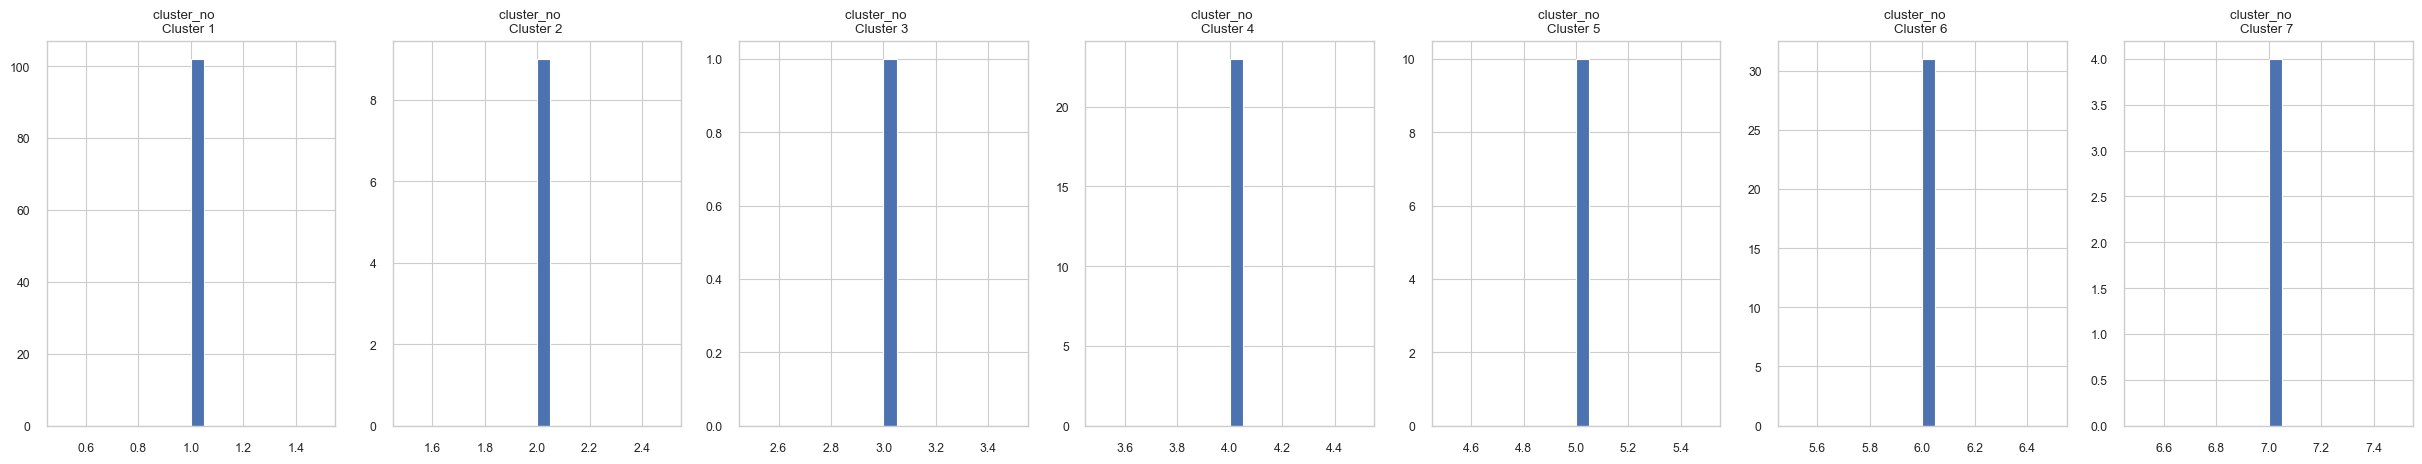

In [35]:
for i in prod19_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(1,8):
    plt.subplot(1,8,j+1)
    cluster = prod19_df[prod19_df['cluster_no'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()

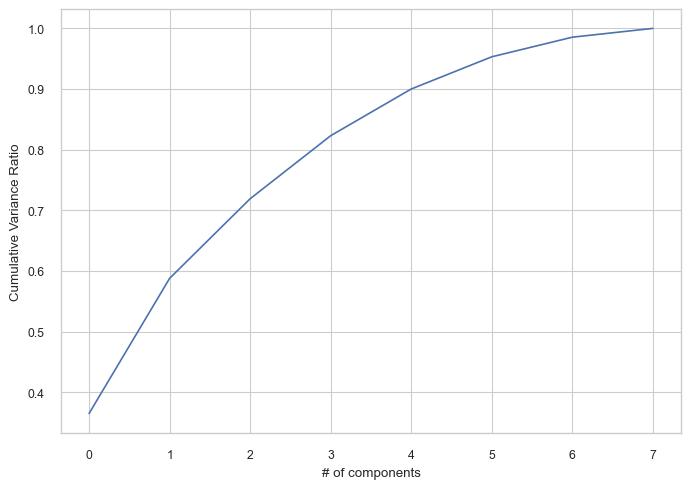

In [36]:
pca = PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of components")
plt.ylabel("Cumulative Variance Ratio")
plt.show()

In [37]:
for i in range(prod19_df.shape[1]-1):
    pca = PCA(n_components=i)
    pca_fit = pca.fit_transform(data_scaled)
    print(i, pca.explained_variance_ratio_.sum())

0 0.0
1 0.36511656043172747
2 0.5878894816156166
3 0.7191155218650638
4 0.8230408114849458
5 0.900051130035674
6 0.9531340072917729
7 0.9854788342024459


In [38]:
#Only for easy visualization, we pick 2 variables.
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data_scaled)
pca.explained_variance_ratio_

array([0.36511656, 0.22277292])

In [39]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(pca_fit, index=data_scaled.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

PC1       PC2  cluster
Area                                            
Afghanistan         -0.150391 -0.063182        1
Albania              0.237025  0.656380        2
Algeria             -0.017164  0.257296        6
Angola              -0.193450 -0.061033        1
Antigua and Barbuda -0.242290 -0.046319        1

In [40]:
#https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/functions.py
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
            
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

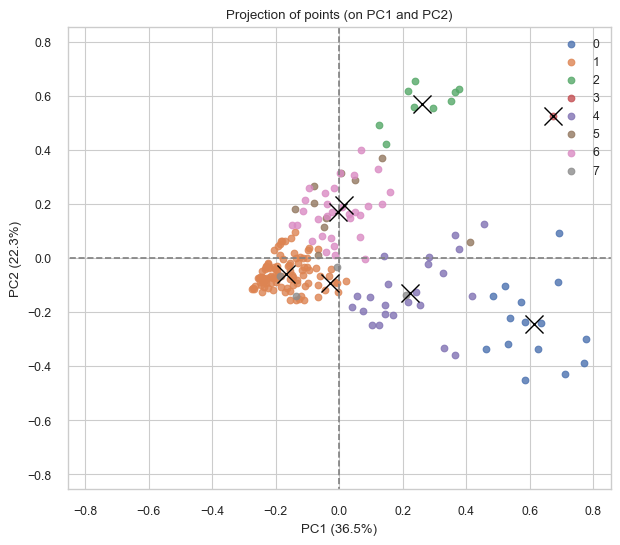

In [41]:
from sklearn.decomposition import PCA
centres_reduced = pca.transform(kmeans.cluster_centers_)
display_factorial_planes(pca_fit, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=1,
            color='black', zorder=10);

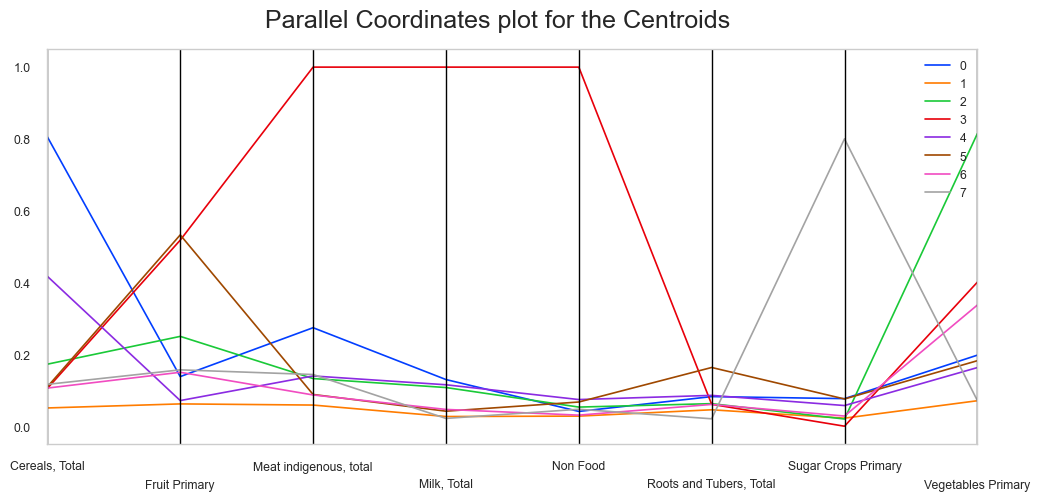

In [42]:
from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)


# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(data_scaled, index=data_scaled.index, columns=data_scaled.columns)
X_clustered["cluster"] = clusters
means =  X_clustered.groupby(by="cluster").mean()
display_parallel_coordinates_centroids(means.reset_index(), 5)

In [43]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data_scaled, 5))

Top Absolute Correlations
Item                    Item                  
Meat indigenous, total  Milk, Total               0.790195
Milk, Total             Non Food                  0.477975
Meat indigenous, total  Non Food                  0.477293
Cereals, Total          Meat indigenous, total    0.380859
Fruit Primary           Vegetables Primary        0.364271
dtype: float64


In [44]:
codes_df = pd.read_csv(pop_folder /"Population_E_AreaCodes.csv", encoding = 'unicode_escape')

In [45]:
prod19_df=prod19_df.merge(codes_df, on='Area')

In [46]:
import country_converter as coco
cc = coco.CountryConverter()
prod19_df['iso']=cc.pandas_convert(prod19_df['Area'], to='ISO3')

In [47]:
pd.set_option('display.max_rows', None)

In [48]:
import plotly.express as px

In [49]:
fig = px.choropleth(prod19_df, 
                    locations=prod19_df['iso'], 
                    color="cluster_no",
                     hover_name="cluster_no",
                    labels={'cluster_no':'Cluster'},
                    title='foo',
                    color_continuous_scale=px.colors.sequential.Plasma,
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(title_text='Map of countries by cluster',title_x = 0.4, title_y=0.9,margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [50]:

cluster_ire=prod19_df['cluster_no'][prod19_df['Area']=='Ireland'].values[0]
print("Regions in the same cluster than Ireland: \n")
#use to_string function to remove the "Name", "Dtype" from the output. 
print(prod19_df['Area'][prod19_df['cluster_no']==cluster_ire].to_string(index=False))

Regions in the same cluster than Ireland: 

                         Austria
                      Bangladesh
                         Belarus
                        Cambodia
                         Croatia
                         Czechia
                         Estonia
                         Finland
                          France
                         Germany
                          Guinea
                         Ireland
                      Kazakhstan
Lao People's Democratic Republic
                            Mali
                         Myanmar
                          Poland
              Russian Federation
                        Slovakia
                        Suriname
                          Sweden
                        Thailand
                        Viet Nam


In [103]:
prod19_df[prod19_df['cluster_no']==cluster_ire].head()

Area  Cereals, Total  Fruit Primary  Meat indigenous, total  \
8      Austria      129.367090      51.851814              244.388476   
12  Bangladesh      134.773630      14.964878               16.057212   
14     Belarus      156.858130      37.247579              312.594900   
28    Cambodia      273.747997       9.591463               30.575195   
40     Croatia      176.956147      43.789797              124.603124   

    Milk, Total   Non Food  Roots and Tubers, Total  Sugar Crops Primary  \
8    179.420920   1.280076                21.173229            10.425859   
12     9.966002   7.549592                14.893519             0.906715   
14   318.123964   9.408132               157.946101            24.083285   
28     0.613966  24.551347                68.300244             6.147925   
40    62.397209   4.544099                10.493124             8.083294   

    Vegetables Primary  cluster_no  Area Code M49 Code  iso  
8            23.984622           4         11     '040  AUT  
12           14.477892           4         16     '050  BGD  
14           67.084551           4         57     '112  BLR  
28           11.494751           4        115     '116  KHM  
40           12.333186           4         98     '191  HRV

In [53]:
#prod_wide=pd.wide_to_long(prod_df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()

In [117]:
prod_clust=prod_df

In [118]:
countries_ire = prod19_df["Area"][prod19_df['cluster_no']==cluster_ire].unique()

In [119]:
def select_countries_cluster(country, country_list, max_num):
    if (len(country_list)<= max_num):
        return country_list
    else:
        country_list.remove(country)
        sample_list=[country]
        sample_list+=random.sample(country_list, max_num-1)
        return sorted(sample_list)

In [120]:
sample_countries=select_countries_cluster('Ireland', list(countries_ire), 10)

In [121]:
prod_clust = prod_clust[prod_clust["Area"].isin(sample_countries)]
prod_clust = prod_clust[prod_clust["Item"].isin(['Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary'])]
prod_clust = prod_clust[prod_clust["Year"]>1999]

In [122]:
prod_clust= prod_clust.merge(pop_df[["Area", "Year", "Total_Population"]], how='left', on=['Area', 'Year'])
prod_clust["Prod_pop"]=prod_clust["Total_Prod"]/prod_clust["Total_Population"]

In [97]:
#create_report(prod_wide).show_browser()

In [98]:
#STREAMLIT APP

for item in prod_wide['Item'].unique():
    fig = plt.figure(figsize=(8,7))
    plt.title(item)
    sns.lineplot(data=prod_wide[prod_wide['Item']==item].drop('Item', axis=1), x='Year', y='Y', hue='Area')
    st.pyplot(fig)

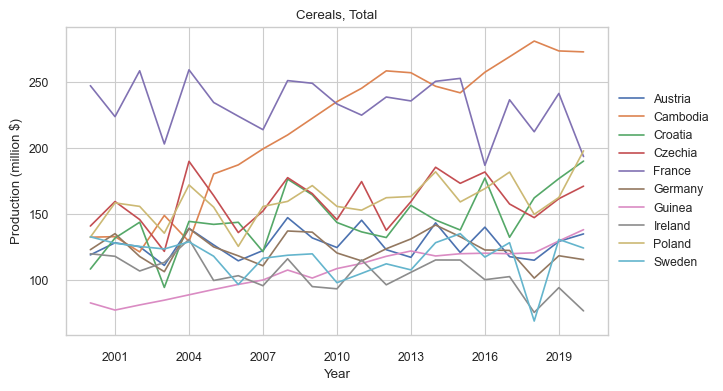

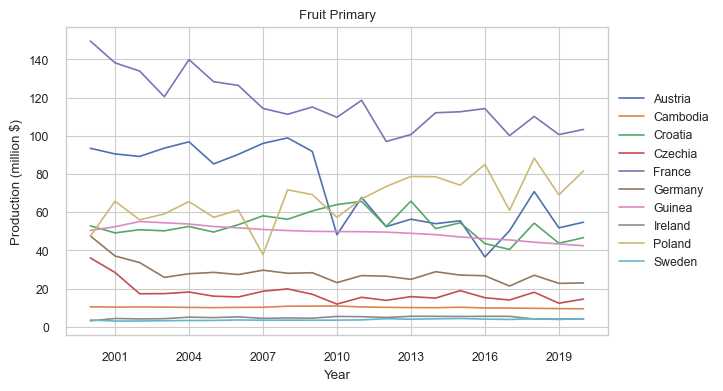

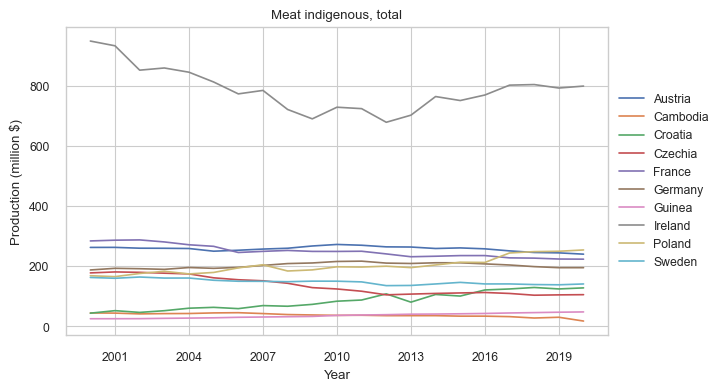

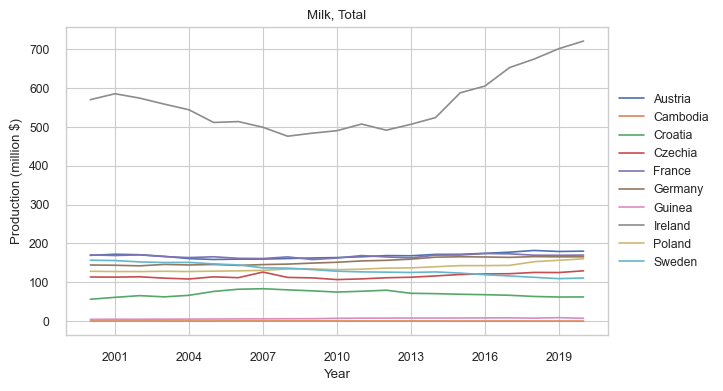

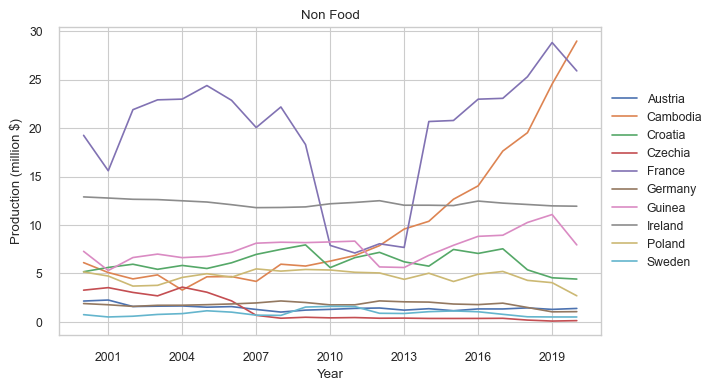

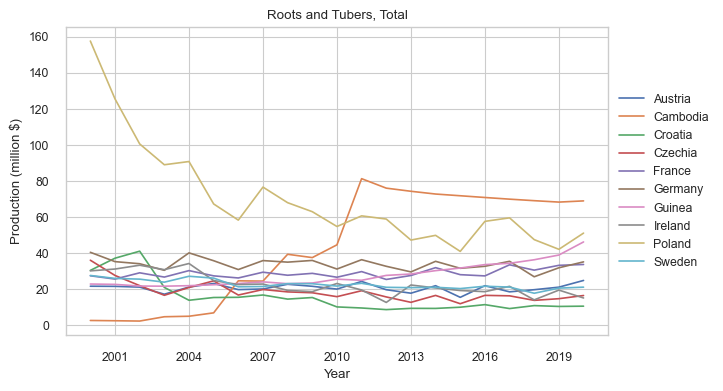

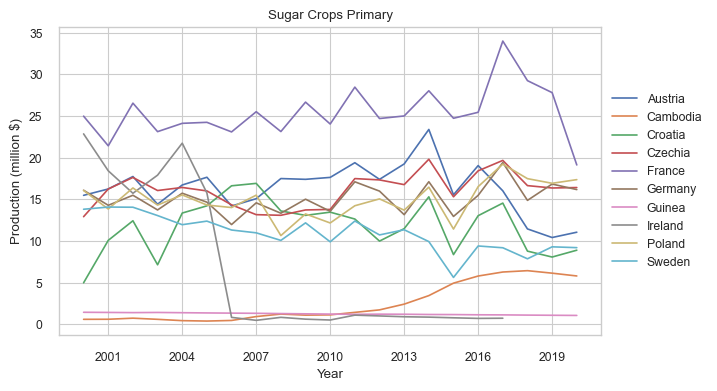

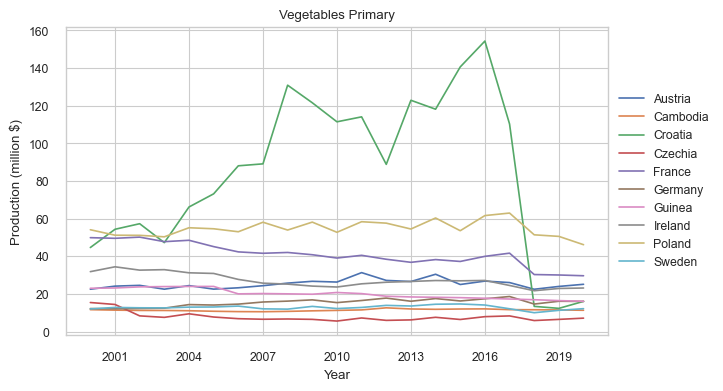

In [126]:
for item in prod_clust['Item'].unique():
    fig = plt.figure(figsize=(7,4))
    ax = plt.subplot(111)
    plt.title(item)
    sns.lineplot(data=prod_clust[prod_clust['Item']==item].drop('Item', axis=1), x='Year', y='Prod_pop', hue='Area')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Production (million $)')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show(fig)